In [30]:
import gpytorch
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from gpytorch.kernels import RBFKernel

from matplotlib import pyplot as plt
%matplotlib inline

In [31]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x) # p(f)

In [32]:
def inv_softplus(x):
    return math.log(math.exp(x) - 1)

inv_softplus(1)

0.541324854612918

In [33]:
# Define function to calculate bias and variance
def calculate_bias_variance(gp, likelihood, x_test, true_function_values, n_observed):
    # Make predictions using the GP
    gp.eval()
    likelihood.eval()
    
    f_preds = gp(x_test)
    pred_means = f_preds.mean.detach().numpy()  # Predicted mean values
    pred_std = f_preds.stddev.detach().numpy()  # Predicted std deviation (uncertainty)

    # Subset the predicted values to match the true values
    # We only compare predictions at the same points as the training points
    pred_means_subset = pred_means[:n_observed]  # Match the number of observed points
    pred_std_subset = pred_std[:n_observed]  # Match the number of observed points

    # Compute bias (mean prediction error)
    bias = pred_means_subset - true_function_values  # Bias only for observed points
    
    # Compute variance (predictive variance)
    variance = pred_std_subset**2  # variance is the square of the standard deviation
    
    return bias, variance

### Prepare data

In [34]:
true_lengthscale=4.
true_noise=0.2
true_outputscale=1.
N = 300
I = 100

In [35]:
def generate_dataset(seed=7):
    
    x = np.arange(0., N)
    np.random.seed(seed)
    torch.manual_seed(seed)
    x = torch.from_numpy(x).float()

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood.noise_covar.raw_noise.data = torch.tensor([inv_softplus(true_noise**2)])

    kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    kernel.base_kernel.raw_lengthscale.data = torch.tensor([inv_softplus(true_lengthscale)])
    kernel.raw_outputscale.data = torch.tensor(inv_softplus(true_outputscale))

    gp = ExactGPModel(
        train_x=None,
        train_y=None,
        likelihood=likelihood,
        kernel=kernel
    )

    gp.eval()
    f_preds = gp(x)
    y_preds = likelihood(f_preds)
    y = y_preds.rsample().detach()
    # order = np.arange(len(x))
    # np.random.shuffle(order)
    # order = torch.from_numpy(order).long()
    # x, y = x[order], y[order]

    return x, y

Text(0.5, 1.0, 'Data')

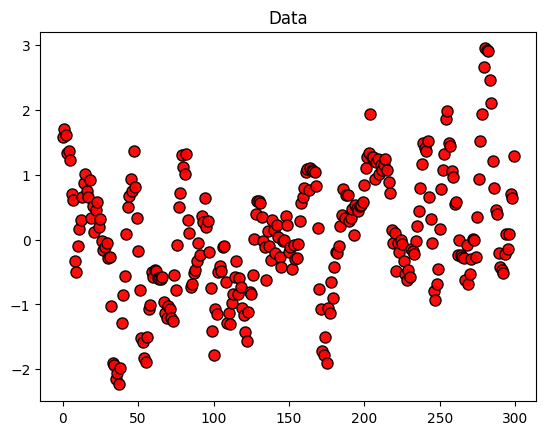

In [36]:
datasets = [generate_dataset(seed=i) for i in range(100)]

x, y = datasets[19]

plt.plot(x, y, "ro", ms=8, alpha=0.95, mec="k")
# plt.plot(x_, f, "--k", alpha=0.95)
plt.title("Data")

## Experiment from the Human Kernel paper

In [37]:
def get_initial_gp(x, y):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood.noise_covar.raw_noise.data = torch.tensor([inv_softplus(true_noise**2)])

    kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    kernel.base_kernel.raw_lengthscale.data = torch.tensor([inv_softplus(true_lengthscale)])
    kernel.raw_outputscale.data = torch.tensor(inv_softplus(true_outputscale))

    gp = ExactGPModel(
        train_x=x,
        train_y=y,
        likelihood=likelihood,
        kernel=kernel
    )
    return gp, likelihood

In [38]:
def optimize_mll(gp, likelihood, x, y, training_iter=I, verbose=False, print_frec=100):
    gp.train()
    likelihood.train()

#     optimizer = torch.optim.Adam(gp.parameters(), lr=0.01)
    optimizer = torch.optim.Adam([gp.covar_module.base_kernel.raw_lengthscale], lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

    for i in range(training_iter):
        optimizer.zero_grad()
        output = gp(x)
        loss = -mll(output, y)
        loss.backward()
        if verbose and (i % print_frec == 0):
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f  noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                gp.covar_module.base_kernel.lengthscale.item(),
                gp.likelihood.noise.item()
        ))
        optimizer.step()
    return gp, likelihood


def MLL(gp, x, y):
    N = len(x)
    covar_matrix = gp.covar_module(x, x).evaluate()
    covar_matrix = covar_matrix + gp.likelihood.noise * torch.eye(N).to(x.device)
    log_mll = - 0.5 * (y.T @ torch.inverse(covar_matrix)) @ y 
    log_mll += - 0.5 * torch.logdet(covar_matrix)
    log_mll += - 0.5 * N * np.log(2 * np.pi)

    return log_mll


def CondtionalMLL(gp, x, y, xm, ym):
    return MLL(gp, x, y) - MLL(gp, xm, ym)


def optimize_cmll(gp, likelihood, x, y, n_cond, training_iter=I, verbose=False, print_frec=100):
    x, y = x.clone(), y.clone()
    gp.train()
    likelihood.train()
    optimizer = torch.optim.Adam([gp.covar_module.base_kernel.raw_lengthscale], lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

    for i in range(training_iter):
        idx = torch.randperm(len(x))[:n_cond]
        optimizer.zero_grad()
        loss = -CondtionalMLL(gp, x, y, x[idx], y[idx])
        loss.backward()
        if verbose and (i % print_frec == 0):
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f  noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                gp.covar_module.base_kernel.lengthscale.item(),
                gp.likelihood.noise.item()
        ))
        optimizer.step()
    return gp, likelihood

In [39]:
lengthscales = []
# clml_lengthscales = []

for ds in tqdm.tqdm(datasets[3:10]):
    ds_lengthscales = []
    # ds_clml_lengthscales = []
    for n_observed in range(1, N):
        x, y = ds
        x, y = x[:n_observed], y[:n_observed]
        # Optimize LML
        gp, likelihood = get_initial_gp(x, y)
        gp, likelihood = optimize_mll(gp, likelihood, x, y, training_iter=I)
        lengthscale = gp.covar_module.base_kernel.lengthscale.detach().numpy().item()
        ds_lengthscales.append(lengthscale)
        
        # Optimize CLML
        # n_cond = int(0.9 * n_observed)
        # gp, likelihood = get_initial_gp(x, y)
        # gp, likelihood = optimize_cmll(gp, likelihood, x, y, n_cond=n_cond, training_iter=1000)
        # lengthscale = gp.covar_module.base_kernel.lengthscale.detach().numpy().item()
        # ds_clml_lengthscales.append(lengthscale)

    # clml_lengthscales.append(ds_clml_lengthscales)
    lengthscales.append(ds_lengthscales)
lengthscales = np.array(lengthscales)
# clml_lengthscales = np.array(clml_lengthscales)

100%|██████████| 7/7 [08:24<00:00, 72.07s/it]


In [40]:
# lengthscales = []
clml_lengthscales = []

for ds in tqdm.tqdm(datasets[3:10]):
#     ds_lengthscales = []
    ds_clml_lengthscales = []
    for n_observed in range(1, N):
        x, y = ds
        x, y = x[:n_observed], y[:n_observed]
        # Optimize LML
#         gp, likelihood = get_initial_gp(x, y)
#         gp, likelihood = optimize_mll(gp, likelihood, x, y, training_iter=1000)
#         lengthscale = gp.covar_module.base_kernel.lengthscale.detach().numpy().item()
#         ds_lengthscales.append(lengthscale)
        
        # Optimize CLML
        n_cond = int(0.9 * n_observed)
        gp, likelihood = get_initial_gp(x, y)
        gp, likelihood = optimize_cmll(gp, likelihood, x, y, n_cond=n_cond, training_iter=I)
        lengthscale = gp.covar_module.base_kernel.lengthscale.detach().numpy().item()
        ds_clml_lengthscales.append(lengthscale)

    clml_lengthscales.append(ds_clml_lengthscales)
#     lengthscales.append(ds_lengthscales)
# lengthscales = np.array(lengthscales)
clml_lengthscales = np.array(clml_lengthscales)

100%|██████████| 7/7 [19:04<00:00, 163.49s/it]


Text(0.5, 1.0, 'LML 300, 100')

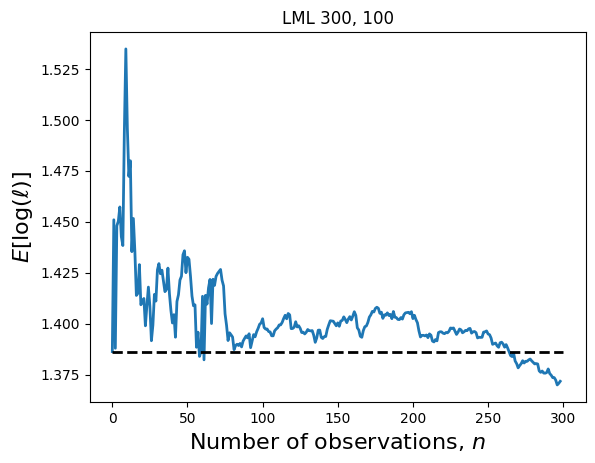

In [41]:
plt.plot(np.mean(np.log(lengthscales), axis=0), lw=2)
plt.plot([0, N], [np.log(4)] * 2, "--k", lw=2)
plt.ylabel(r"$E[\log(\ell)]$", fontsize=16)
plt.xlabel(r"Number of observations, $n$", fontsize=16)
plt.title(f"LML {N}, {I}")


Text(0.5, 1.0, 'CLML 300, 100')

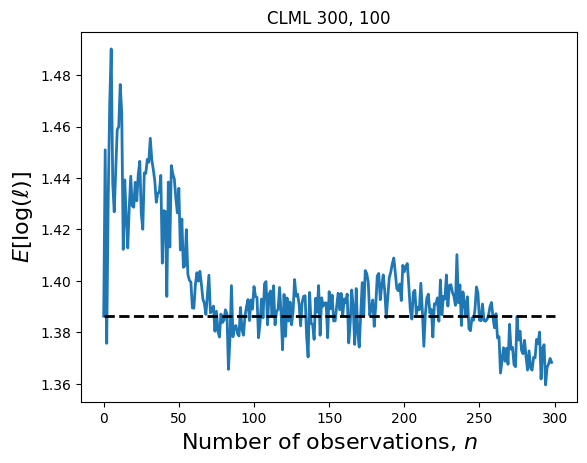

In [42]:
plt.plot(np.mean(np.log(clml_lengthscales), axis=0), lw=2)
plt.plot([0, N], [np.log(4)] * 2, "--k", lw=2)
plt.ylabel(r"$E[\log(\ell)]$", fontsize=16)
plt.xlabel(r"Number of observations, $n$", fontsize=16)
plt.title(f"CLML {N}, {I}")


In [43]:
np.savez(f"plots/human_kernel_results_mll{N}{I}.npz",
        lengthscales=lengthscales)
np.savez(f"plots/human_kernel_results_clml{N}{I}.npz",
        clml_lengthscales=clml_lengthscales)


In [44]:
lengthscales = np.load(f"plots/human_kernel_results_mll{N}{I}.npz")["lengthscales"]
clml_lengthscales = np.load(f"plots/human_kernel_results_clml{N}{I}.npz")["clml_lengthscales"]

In [45]:
np.argmax(lengthscales[:, -1])
np.argmax(clml_lengthscales[:, -1])

6

## True GP fit

In [46]:
n_observed = 199
data_i = 12

(-1.0, 200.0)

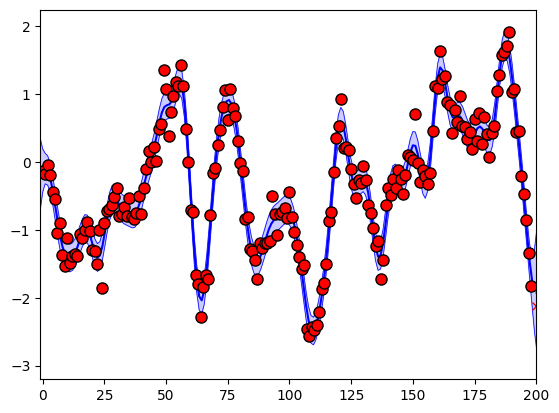

In [47]:
x_test = torch.linspace(-1, N, 300)

x, y = datasets[data_i]

gp, likelihood = get_initial_gp(x[:n_observed], y[:n_observed])

gp.eval()
likelihood.eval()

f_preds = gp(x_test)
pred_means = f_preds.mean.detach().numpy()
pred_std = f_preds.stddev.detach().numpy()

plt.plot(x_test.detach().numpy(), pred_means, "-b")
plt.plot(x_test.detach().numpy(), pred_means + 2 * pred_std, "-b", lw=.5)
plt.plot(x_test.detach().numpy(), pred_means - 2 * pred_std, "-b", lw=.5)
plt.fill_between(x_test.detach().numpy(), 
                 pred_means + 2 * pred_std,
                 pred_means - 2 * pred_std,
                 color="b", alpha=0.2)

plt.plot(x[:n_observed].detach().numpy(), y[:n_observed].detach().numpy(), "ro", ms=8, mec="k")
plt.plot(x[n_observed:].detach().numpy(), y[n_observed:].detach().numpy(), "rx")
plt.xlim(-1, n_observed+1)

## Optimization

In [48]:
# x, y = datasets[3]
gp, likelihood = get_initial_gp(x[:n_observed], y[:n_observed])
gp, likelihood = optimize_mll(gp, likelihood, x[:n_observed], y[:n_observed], training_iter=I, verbose=True)

Iter 1/100 - Loss: 0.308   lengthscale: 4.000  noise: 0.040


(-1.0, 200.0)

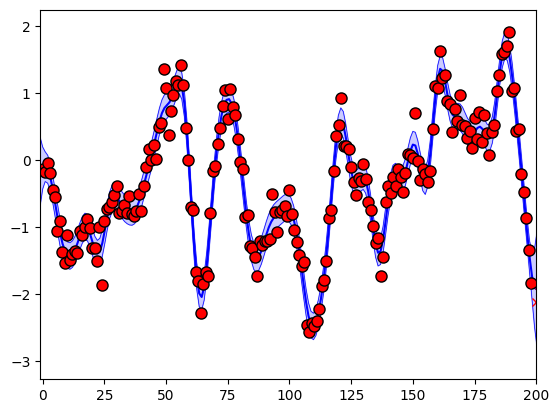

In [50]:
gp.eval()
likelihood.eval()
true_function_values = y[:n_observed].detach().numpy()  # Approximate true values using observed data

bias, variance = calculate_bias_variance(gp, likelihood, x_test, true_function_values, n_observed)

f_preds = gp(x_test)
pred_means = f_preds.mean.detach().numpy()
pred_std = f_preds.stddev.detach().numpy()

plt.plot(x_test.detach().numpy(), pred_means, "-b")
plt.plot(x_test.detach().numpy(), pred_means + 2 * pred_std, "-b", lw=.5)
plt.plot(x_test.detach().numpy(), pred_means - 2 * pred_std, "-b", lw=.5)
plt.fill_between(x_test.detach().numpy(), 
                 pred_means + 2 * pred_std,
                 pred_means - 2 * pred_std,
                 color="b", alpha=0.2)

plt.plot(x[:n_observed].detach().numpy(), y[:n_observed].detach().numpy(), "ro", ms=8, mec="k")
plt.plot(x[n_observed:].detach().numpy(), y[n_observed:].detach().numpy(), "rx")
plt.xlim(-1, n_observed+1)

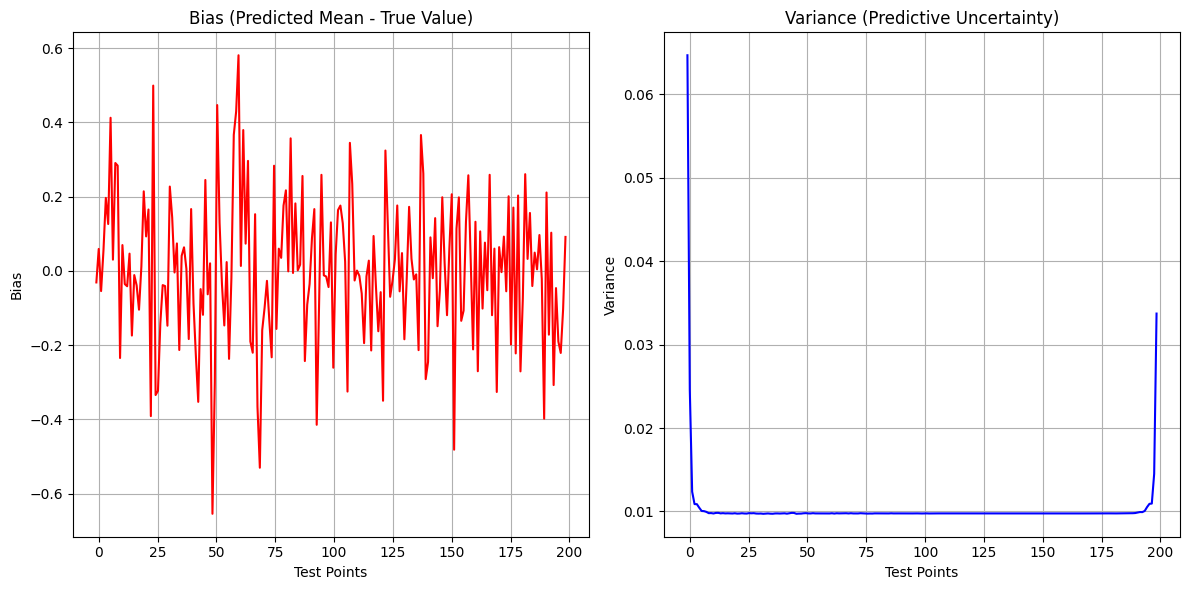

In [51]:
plt.figure(figsize=(12, 6))

# Plot Bias
plt.subplot(1, 2, 1)
plt.plot(x_test.detach().numpy()[:n_observed], bias, label="Bias", color='red')  # Plot only for the observed points
plt.title("Bias (Predicted Mean - True Value)")
plt.xlabel("Test Points")
plt.ylabel("Bias")
plt.grid(True)

# Plot Variance
plt.subplot(1, 2, 2)
plt.plot(x_test.detach().numpy()[:n_observed], variance, label="Variance", color='blue')  # Plot only for the observed points
plt.title("Variance (Predictive Uncertainty)")
plt.xlabel("Test Points")
plt.ylabel("Variance")
plt.grid(True)

plt.tight_layout()
plt.show()

## CMLL Optimization

In [52]:
# x, y = datasets[3]
true_function_values = y[:n_observed].detach().numpy()  # Approximate true values using observed data

gp, likelihood = get_initial_gp(x[:n_observed], y[:n_observed])
gp, likelihood = optimize_cmll(gp, likelihood, x[:n_observed], y[:n_observed], n_cond=120, 
                               training_iter=1000, verbose=True)

Iter 1/1000 - Loss: -4.036   lengthscale: 4.000  noise: 0.040
Iter 101/1000 - Loss: 1.878   lengthscale: 4.241  noise: 0.040
Iter 201/1000 - Loss: 4.289   lengthscale: 4.170  noise: 0.040
Iter 301/1000 - Loss: 9.466   lengthscale: 4.164  noise: 0.040
Iter 401/1000 - Loss: -5.255   lengthscale: 4.232  noise: 0.040
Iter 501/1000 - Loss: -0.455   lengthscale: 4.122  noise: 0.040
Iter 601/1000 - Loss: 5.489   lengthscale: 4.184  noise: 0.040
Iter 701/1000 - Loss: -1.643   lengthscale: 4.214  noise: 0.040
Iter 801/1000 - Loss: 7.139   lengthscale: 4.221  noise: 0.040
Iter 901/1000 - Loss: 10.555   lengthscale: 4.150  noise: 0.040


(-1.0, 200.0)

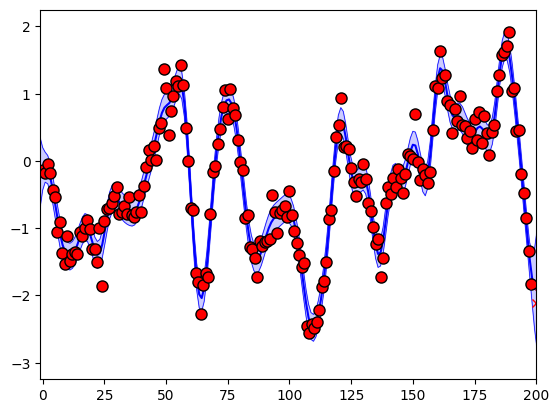

In [ ]:
gp.eval()
likelihood.eval()

bias, variance = calculate_bias_variance(gp, likelihood, x_test, true_function_values, n_observed)


f_preds = gp(x_test)
pred_means = f_preds.mean.detach().numpy()
pred_std = f_preds.stddev.detach().numpy()

plt.plot(x_test.detach().numpy(), pred_means, "-b")
plt.plot(x_test.detach().numpy(), pred_means + 2 * pred_std, "-b", lw=.5)
plt.plot(x_test.detach().numpy(), pred_means - 2 * pred_std, "-b", lw=.5)
plt.fill_between(x_test.detach().numpy(), 
                 pred_means + 2 * pred_std,
                 pred_means - 2 * pred_std,
                 color="b", alpha=0.2)

plt.plot(x[:n_observed].detach().numpy(), y[:n_observed].detach().numpy(), "ro", ms=8, mec="k")
plt.plot(x[n_observed:].detach().numpy(), y[n_observed:].detach().numpy(), "rx")
plt.xlim(-1, n_observed+1)

In [ ]:
plt.figure(figsize=(12, 6))

# Plot Bias
plt.subplot(1, 2, 1)
plt.plot(x_test.detach().numpy()[:n_observed], bias, label="Bias", color='red')  # Plot only for the observed points
plt.title("Bias (Predicted Mean - True Value)")
plt.xlabel("Test Points")
plt.ylabel("Bias")
plt.grid(True)

# Plot Variance
plt.subplot(1, 2, 2)
plt.plot(x_test.detach().numpy()[:n_observed], variance, label="Variance", color='blue')  # Plot only for the observed points
plt.title("Variance (Predictive Uncertainty)")
plt.xlabel("Test Points")
plt.ylabel("Variance")
plt.grid(True)

plt.tight_layout()
plt.show()